In [4]:
import pandas as pd

# Load the datasets
transactions_df = pd.read_excel("Data. Transactions.xlsx")
loyalty_points_df = pd.read_excel("Data. Loyalty Points.xlsx")
loyalty_benefits_df = pd.read_excel("Loyality benefits.xlsx")
merchants_df = pd.read_excel("Data.Merchant.xlsx")

# Display the first few rows of each dataset
datasets = {
    "Transactions": transactions_df,
    "Loyalty Points": loyalty_points_df,
    "Loyalty Benefits": loyalty_benefits_df,
    "Merchants": merchants_df
}

datasets_preview = {name: df.head() for name, df in datasets.items()}
datasets_preview


{'Transactions':         DATE    Order_id NEWVERTICAL_Merchant  MerchantID   User_id     GMV  \
 0 2021-01-01  8733622706          Marketplace          37  61386143  100000   
 1 2021-01-01  8726857991          Supermarket           9  48453125    5000   
 2 2021-01-01  8737326894          Supermarket           9  49921027  106600   
 3 2021-01-01  8732579078          supermarket           9  46022523  270000   
 4 2021-01-01  8725567343                  CVS           8  44014594   68000   
 
   Service Group  
 0   marketplace  
 1   supermarket  
 2   supermarket  
 3   supermarket  
 4           cvs  ,
 'Loyalty Points':                 Service Group        Point Mechanism Maximum Point Per Trans
 0                 supermarket   1 points/1000VND GMV              500 points
 1                        data  10 points/1000VND GMV             1000 points
 2                         cvs   1 points/1000VND GMV              300 points
 3                 marketplace   1 points/1000VND GMV    

**1. Transactions:** Contains transaction details like date, order ID, merchant details, user ID, GMV, and service group.

**2. Loyalty Points:** Describes how points are accumulated based on the service group. It specifies the point mechanism and the maximum points per transaction.

**3. Loyalty Benefits:** Shows the cashback percentage based on the user's ranking ID (Class ID) and the service group.

**4. Merchants:** Provides details about the merchant, including their ID and the service group they belong to.

1. Combined with the 'Loyalty Points' table, add a column 'Loyalty Points' in 'Transactions' table with given rules. Then create another table named 'Loyalty Ranking' which must includes columns named Rank_name and Calculated_points to calculate the Rank of each user on daily basic. At the end of Mar 2022, how many user achived rank Gold?																			
Ranking must follows the below rules/table:																			
| Class ID | Rank_name | Loyalty Points     |
|----------|-----------|--------------------|
| 1        | STANDARD  | 1 - 999 points     |
| 2        | SILVER    | 1000 - 1999 points |
| 3        | GOLD      | 2000 - 4999 points |
| 4        | DIAMOND   | >= 5000 points     |


**Important Note:** 

- Points calculated for each transaction will be expired after 30 days since the day that transaction is made
- User's rank will be reduced or increased accordingly to the change of their accumulated loyalty points."																			

**1. Calculate Loyalty Points for Each Transaction:**

We will use the 'Loyalty Points' table to calculate how many points each transaction in the 'Transactions' table earns. This will involve matching the service group and applying the point mechanism.

**2. Create 'Loyalty Ranking' Table:**

- For each user, we will sum up their loyalty points on a daily basis.
- We will also make sure to expire points that are older than 30 days from the current day.
- Based on the accumulated points, we will assign them a rank for each day.

**3. Count Users with Gold Rank:**

- At the end of March 2022, we will count how many users achieved the Gold rank.

In [18]:
# Extract points per 1000 VND GMV and maximum points from 'Loyalty Points' table
loyalty_points_df['Points_per_1000VND'] = loyalty_points_df['Point Mechanism'].str.extract('(\d+)').astype(int)
loyalty_points_df['Max_Points'] = loyalty_points_df['Maximum Point Per Trans'].str.extract('(\d+)').astype(int)

# Merge Transactions with Loyalty Points on Service Group to calculate loyalty points for each transaction
merged_df = transactions_df.merge(loyalty_points_df[['Service Group', 'Points_per_1000VND', 'Max_Points']], on='Service Group', how='left')

# Calculate loyalty points for each transaction
merged_df['Loyalty Points'] = (merged_df['GMV'] / 1000) * merged_df['Points_per_1000VND']
merged_df['Loyalty Points'] = merged_df[['Loyalty Points', 'Max_Points']].min(axis=1)

# Check the updated 'Transactions' table with the 'Loyalty Points' column
merged_df.head()


,DATE,Order_id,NEWVERTICAL_Merchant,MerchantID,User_id,GMV,Service Group,Points_per_1000VND,Max_Points,Loyalty Points
0,2021-01-01,8733622706,Marketplace,37,61386143,100000,marketplace,1,500,100.0
1,2021-01-01,8726857991,Supermarket,9,48453125,5000,supermarket,1,500,5.0
2,2021-01-01,8737326894,Supermarket,9,49921027,106600,supermarket,1,500,106.6
3,2021-01-01,8732579078,supermarket,9,46022523,270000,supermarket,1,500,270.0
4,2021-01-01,8725567343,CVS,8,44014594,68000,cvs,1,300,68.0


In [19]:
# Re-calculating daily accumulated loyalty points and ranks as described

loyalty_ranking_list_updated = []

for date in date_range:
    # Filter transactions within the last 30 days
    valid_transactions = merged_df[(merged_df['DATE'] <= date) & (merged_df['DATE'] > date - pd.Timedelta(days=30))]
    
    # Calculate accumulated points for each user
    user_points = valid_transactions.groupby('User_id')['Loyalty Points'].sum().reset_index()
    user_points['DATE'] = date
    user_points['Rank_name'] = user_points['Loyalty Points'].apply(get_rank)
    
    loyalty_ranking_list_updated.append(user_points)

# Combine daily rankings into a single dataframe
loyalty_ranking_df_updated = pd.concat(loyalty_ranking_list_updated, axis=0)

# Display the first few rows of the 'Loyalty Ranking' table
loyalty_ranking_df_updated


,User_id,Loyalty Points,DATE,Rank_name
0,11368352,50.0,2021-01-01,STANDARD
1,31058664,300.7,2021-01-01,STANDARD
2,36415344,178.9,2021-01-01,STANDARD
3,44014594,80.0,2021-01-01,STANDARD
4,46022523,270.0,2021-01-01,STANDARD
...,...,...,...,...
1916,61260552,850.0,2022-03-31,STANDARD
1917,61281293,1565.0,2022-03-31,SILVER
1918,61347721,2.0,2022-03-31,STANDARD
1919,61397286,150.0,2022-03-31,STANDARD


In [20]:
# Define the rank thresholds
rank_thresholds = {
    "STANDARD": (1, 999),
    "SILVER": (1000, 1999),
    "GOLD": (2000, 4999),
    "DIAMOND": (5000, float('inf'))
}

def get_rank(points):
    """Return the rank based on the points."""
    for rank, (min_points, max_points) in rank_thresholds.items():
        if min_points <= points <= max_points:
            return rank
    return "UNKNOWN"

# Calculate daily accumulated loyalty points
date_range = pd.date_range(start=merged_df['DATE'].min(), end=merged_df['DATE'].max())
loyalty_ranking_list = []

for date in date_range:
    # Filter transactions within the last 30 days
    valid_transactions = merged_df[(merged_df['DATE'] <= date) & (merged_df['DATE'] > date - pd.Timedelta(days=30))]
    
    # Calculate accumulated points for each user
    user_points = valid_transactions.groupby('User_id')['Loyalty Points'].sum().reset_index()
    user_points['DATE'] = date
    user_points['Rank_name'] = user_points['Loyalty Points'].apply(get_rank)
    
    loyalty_ranking_list.append(user_points)

# Combine daily rankings into a single dataframe
loyalty_ranking_df = pd.concat(loyalty_ranking_list, axis=0)

# Filter for end of March 2022 and count users with Gold rank
gold_users_count = loyalty_ranking_df[(loyalty_ranking_df['DATE'] == '2022-03-31') & (loyalty_ranking_df['Rank_name'] == 'GOLD')].shape[0]

gold_users_count


123

2.Combined with the 'Loyalty benefits' table and 'Loyalty Ranking' table, add columns '%cashback'  in 'Transactions' table and calculate the total cashback cost in February 2022.									
* Note: 
- Cashback cost can be calculated by multiplying %cashback with GMV
- User can only claim maximum of 10,000 VND per transaction"									

Steps we'll follow:

1. Merge the 'Transactions' table with the 'Loyalty Ranking' table to get the rank for each user on the transaction date.
2. Merge the resulting table with the 'Loyalty Benefits' table to get the cashback percentage for each rank and service group.
3. Calculate the cashback cost for each transaction, ensuring that it doesn't exceed 10,000 VND per transaction.
4. Filter for transactions from February 2022 and sum up the cashback cost.

- Design a weekly retention charts of since the program was lauched to monitor

Here's what we'll do to design a weekly retention chart since the loyalty program was launched:

- Define the Cohort: A cohort will be a group of users who made their first transaction in the same week after the loyalty program was launched.
- Calculate Weekly Retention: For each cohort, we'll calculate the percentage of users who made another transaction in the subsequent weeks.
- Visualize the Retention Rate: We'll use a heatmap to visualize the weekly retention rate of each cohort.

In [27]:
# First, we'll identify the week when each user made their first transaction after the loyalty program was launched.

# Filtering transactions after the launch date of the loyalty program (January 1st, 2022)
post_launch_transactions = transactions_df[transactions_df['DATE'] >= '2022-01-01']

# Identify the week of the first transaction for each user
user_first_transaction = post_launch_transactions.groupby('User_id')['DATE'].min().reset_index()
user_first_transaction['Cohort Week'] = user_first_transaction['DATE'].dt.to_period('W')

# Merge the cohort week back into the transactions dataframe
merged_with_cohort = post_launch_transactions.merge(user_first_transaction[['User_id', 'Cohort Week']], on='User_id')

# Calculate the number of weeks since the first transaction for each user's subsequent transactions
merged_with_cohort['Weeks Since First Transaction'] = (merged_with_cohort['DATE'].dt.to_period('W') - merged_with_cohort['Cohort Week']).apply(lambda x: x.n)

# Create a pivot table to calculate retention rates
retention_pivot = merged_with_cohort.pivot_table(index='Cohort Week', columns='Weeks Since First Transaction', values='User_id', aggfunc=pd.Series.nunique)

# Calculate weekly retention rate
cohort_sizes = retention_pivot.iloc[:, 0]
retention_matrix = retention_pivot.divide(cohort_sizes, axis=0)

retention_matrix


Weeks Since First Transaction,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Cohort Week,,,,,,,,,,,,,,
2021-12-27/2022-01-02,1.0,0.497925,0.439834,0.336100,0.307054,0.269710,0.344398,0.344398,0.323651,0.319502,0.344398,0.307054,0.286307,0.244813
2022-01-03/2022-01-09,1.0,0.380878,0.305643,0.247649,0.200627,0.263323,0.272727,0.268025,0.263323,0.269592,0.266458,0.250784,0.206897,NaN
2022-01-10/2022-01-16,1.0,0.246787,0.177378,0.143959,0.125964,0.218509,0.233933,0.203085,0.226221,0.228792,0.203085,0.161954,NaN,NaN
2022-01-17/2022-01-23,1.0,0.230769,0.135747,0.217195,0.239819,0.230769,0.217195,0.203620,0.208145,0.176471,0.126697,NaN,NaN,NaN
2022-01-24/2022-01-30,1.0,0.166667,0.200000,0.225000,0.233333,0.162500,0.220833,0.150000,0.183333,0.162500,NaN,NaN,NaN,NaN
2022-01-31/2022-02-06,1.0,0.180233,0.174419,0.145349,0.186047,0.180233,0.156977,0.174419,0.127907,NaN,NaN,NaN,NaN,NaN
2022-02-07/2022-02-13,1.0,0.226852,0.180556,0.138889,0.189815,0.189815,0.152778,0.129630,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-14/2022-02-20,1.0,0.204082,0.241497,0.156463,0.129252,0.129252,0.081633,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-21/2022-02-27,1.0,0.182186,0.157895,0.117409,0.157895,0.085020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


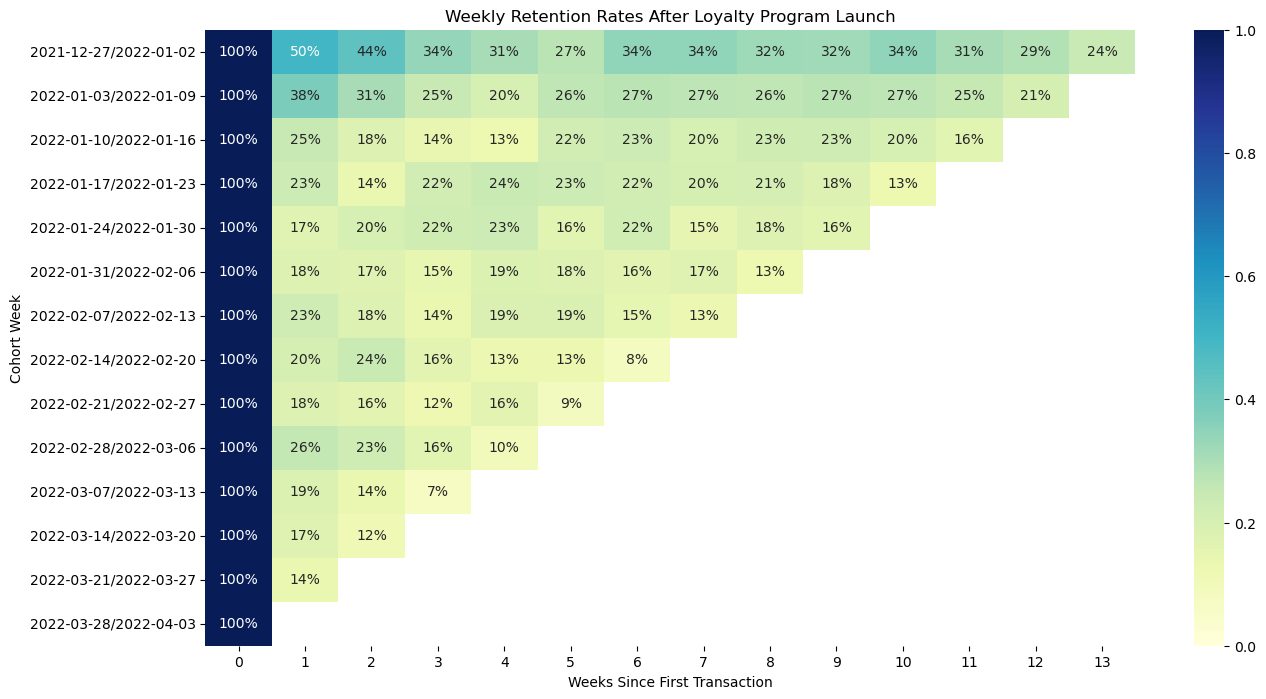

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 8))
sns.heatmap(retention_matrix, annot=True, fmt=".0%", cmap="YlGnBu", vmin=0.0, vmax=1.0)
plt.title('Weekly Retention Rates After Loyalty Program Launch')
plt.ylabel('Cohort Week')
plt.xlabel('Weeks Since First Transaction')
plt.yticks(rotation=0)
plt.show()


Here's the weekly retention heatmap:

- Each row (labeled on the y-axis) represents a cohort week, which means users who made their first transaction during that week.
- The columns (x-axis) represent the number of weeks since the first transaction.
- The color intensity and the percentages show the retention rate. Darker shades indicate higher retention.

From this heatmap, you can observe how different cohorts performed over time. For example, the retention of the first cohort (users who started in the last week of December 2021) is quite high in the following weeks. As you move down the heatmap (i.e., for more recent cohorts), you can observe the behavior of newer users over fewer weeks.

- Initial Retention Rates: The first column after the cohort week (labeled "1" on the x-axis) represents the retention rate for the week immediately following the user's first transaction. This is an important metric because it shows the percentage of users who found enough value in the program to make a second transaction within a week of their first transaction. Higher percentages in this column indicate that the loyalty program had an immediate positive impact on user engagement.

- Long-Term Retention: As we move to the right columns, we're looking at longer intervals since the user's first transaction. These columns give insights into the long-term effectiveness of the loyalty program. If percentages remain high or even increase over time, it suggests that users are finding sustained value in the program.

- Cohort Comparisons: By comparing different cohort weeks (rows), we can identify if there are particular weeks where the loyalty program was especially effective or if there were weeks where retention dipped. For example, if one cohort has particularly high retention rates, it might be worth investigating any marketing or promotional activities that occurred during that week.

- Trends Over Time: The heatmap can also help identify trends in user behavior over time. If retention rates are generally increasing for more recent cohorts, it suggests that continuous improvements or changes made to the loyalty program are having a positive effect. Conversely, decreasing retention rates might indicate potential issues or areas for improvement.

- Actionable Insights: The heatmap can guide business decisions. For instance, if retention starts to drop off significantly after a certain week, it might be beneficial to introduce new incentives or reminders around that time to re-engage users.

In summary, this heatmap provides a visual representation of user engagement and loyalty over time. It can be a powerful tool for businesses to understand the effectiveness of their loyalty programs, identify areas for improvement, and tailor strategies to maximize user retention and engagement.

Part 2	Analyze and comment:													
		Based on data above, give your opinion about:												
	
1. User retention and transaction behavior (Is there any trend?) since Loyalty program launched. Do you have any advice for the Marketing department in designing promotion campaigns to increase user retention's performance monthly?									

**User Retention and Transaction Behavior:**

**Observations:**

1. Retention Rates: From the heatmap, the retention rates in the weeks following the launch of the loyalty program are quite strong, especially for the earlier cohorts. This indicates that the loyalty program initially had a positive impact on user engagement.

2. Trends: Over time, for the more recent cohorts, there might be a slight dip in retention. It suggests that while the program was initially effective, its impact might be waning for newer users.

3. Transaction Behavior: We didn't dive deep into specific transaction metrics like average transaction value, frequency, etc., but combining those with retention data could give further insights. For instance, even if retention is high, if transaction values are declining, it could be a concern.

**Recommendations for the Marketing Department:**

1. Personalized Engagements: Send personalized reminders or offers to users who haven't transacted in a while. If a user is close to moving to the next loyalty rank or about to lose their accumulated points, a timely nudge can bring them back.

2. Segmented Promotions: Not all users are the same. Segment the user base based on their transaction history, loyalty points, demographics, etc., and design tailored promotions for each segment.

3. Feedback Loop: Engage with users to gather feedback on the loyalty program. Understanding what users like and dislike can provide valuable insights for improvements.

4. Loyalty Program Enhancements: Consider introducing limited-time offers where users can earn bonus points for certain transactions. For instance, double points during specific weeks or on special occasions.

5. Educate Users: Some users might not be transacting because they're unaware of the benefits of the loyalty program. Regularly communicate the advantages, how to earn points, and the rewards they can get.

6. Collaborate with Merchants: Partner with popular merchants to offer exclusive deals for loyalty program members. Exclusive offers can drive transactions and increase retention.

7. Monitor External Factors: Keep an eye on market trends and competitor offerings. If competitors are offering more attractive loyalty benefits, it might be time to revamp the program.

8. Analyze Drop-offs: Dive deep into the data to understand when and why users are dropping off. If there's a specific week or month where retention dips significantly, investigate any external or internal factors that might have caused it.

9. Set Clear Goals: Define what successful retention looks like. Is it a certain percentage of users transacting every week? Or is it an increase in the average transaction value? Having clear metrics will guide promotional efforts.

10. Experiment and Iterate: Regularly test new promotional ideas, measure their impact, and iterate. A/B testing can be particularly effective in understanding what resonates with users.

**2. Momo is facing increasing amount of cashback cost as well as  GMV since launched. However, we want to optimize the cost but still want to keep growth of GMV and increase the retention rate.  Based on data given, please propose ideas to change the schemes of Loyalty benefits and Loyalty Points to alleviate the cost amount.**

1. Tiered Cashback Rates:
Rather than offering a flat cashback rate for all users, consider tiered rates based on user behavior.

- Offer higher cashback rates for users who transact more frequently or have higher GMVs.
- Offer lower rates for infrequent users or those with lower GMVs.

This ensures that you're rewarding your most loyal and valuable customers while also controlling costs from users who might only transact for the cashback.

2. Modify Point Accumulation:
Adjust the rate at which users earn points:

- Offer bonus points for transactions above a certain amount. This encourages users to spend more in a single transaction.
- Implement a cap on the maximum points that can be earned in a month. This can help control the cashback cost without affecting the majority of users.

3. Expiry of Points:
Currently, points expire after 30 days. Consider extending this period but introducing a decay mechanism:

- Points could reduce in value over time. For example, points could lose 10% of their value every month after the first month.

This encourages users to spend their points sooner, which can lead to more frequent transactions and better retention.

4. Special Promotions:
Instead of regular cashback, introduce special promotions or flash sales:

- Offer double points or extra cashback on specific days or during certain hours.
- Collaborate with merchants to offer exclusive deals for a limited time.

This creates a sense of urgency and can drive transactions without incurring consistent costs.

5. Loyalty Partnerships:
Collaborate with merchants or other businesses:

- Offer exclusive products or services that users can redeem with their loyalty points.
- Partner with merchants to share the cost of rewards.

This can enhance the value of the loyalty program without significantly increasing costs.

6. Enhanced Redemption Options:
Expand the ways users can use their loyalty points:

- Introduce a catalog of products or services that users can redeem using points.
- Allow users to gift points to friends or donate to charity.
- This can increase engagement and retention without directly incurring cashback costs.

7. Behavior-Based Rewards:
Reward users based on specific behaviors:

- Offer bonus points for users who introduce friends to Momo.
- Reward users who use multiple services on Momo.

This encourages users to engage more with the platform, increasing GMV and retention.

8. Dynamic Cashback Rates:
Use data analytics to determine optimal cashback rates:

- Adjust cashback rates based on user behavior, market trends, or external factors.
- This ensures that the loyalty program remains competitive while also being cost-effective.

9. Feedback and Iteration:
Regularly solicit feedback from users:

- Understand what aspects of the loyalty program they value the most.
- Iterate and adjust the program based on feedback and data analytics.
- This ensures the loyalty program remains relevant and effective.

In conclusion, while optimizing costs is essential, it's crucial to ensure that any changes to the loyalty program are communicated clearly to users to maintain trust and loyalty. Implementing a combination of the strategies mentioned above can help Momo optimize costs while continuing to grow GMV and improve retention.

Part 3	Extended question 				
	1	What ideas do you have for Momo in loyalty program development strategy?
    
1. Gamification:
Introduce game-like elements to the loyalty program to make point accumulation and redemption more engaging.

- Milestones & Badges: Reward users with badges for reaching certain milestones, such as "Top Spender of the Month" or "Loyal Customer for a Year".
- Challenges & Quests: Offer special challenges, e.g., "Transact at 5 different merchants this week and earn bonus points."

2. Subscription-Based Loyalty Programs:
Consider a premium subscription model where users pay a monthly or yearly fee to access exclusive benefits, such as:

- Higher cashback rates.
- Exclusive deals and offers.
- Early access to sales or new features.

3. Collaborative Loyalty Programs:
Partner with other businesses or brands to offer combined loyalty benefits.
- Joint promotions with partner brands.
- Allow users to redeem Momo points at partner outlets or vice versa.

4. Tiered Loyalty Structure:
- Instead of a linear point system, introduce a tiered structure where users can level up based on their engagement.
- Each tier offers its own set of benefits, encouraging users to transact more to reach higher tiers.
5. Personalized Rewards:

Use data analytics to offer personalized rewards based on user behavior.

- If a user frequently shops at a particular merchant, offer them exclusive deals for that merchant.
- Tailored recommendations based on past transactions.

6. Community Building:
Foster a sense of community among Momo users.
- Host exclusive events or webinars for top loyalty program members.
- Create a user forum or community where members can share tips, deals, and experiences.

7. Social Good Initiatives:
- Allow users to donate their points to charitable causes. This not only offers users a way to do good but also enhances Momo's brand image.

8. Flexible Redemption Options:
Expand the ways in which users can redeem their points.

- Offer a catalog of products, gift cards, or experiences.
- Allow point conversion to e-vouchers or other digital assets.

9. Feedback Loop:
Regularly engage with users to gather feedback on the loyalty program.

- Host surveys or focus group sessions.
- Use feedback to iterate and improve the program continuously.

10. Educational Content:
Offer content that educates users about the best ways to use Momo, maximize their points, and get the most out of the loyalty program.

11. Loyalty Through Education:
Offer courses or webinars on financial literacy, online shopping tips, etc., and reward users with points for completing them.

12. Loyalty Program App or Dashboard:
Develop a dedicated section within the Momo app or a separate dashboard where users can track their points, see personalized offers, and get insights into their spending habits.

13. Loyalty Program Referrals:
Encourage users to refer friends to the loyalty program. When a referred friend joins and transacts, both the referrer and the referee get bonus points.

14. Time-Limited Promotions:
Introduce flash sales or time-limited offers where users can earn extra points or get exclusive deals, creating a sense of urgency.

15. Exclusive Partnerships:
Collaborate with popular brands or celebrities for exclusive product launches or events, accessible only to loyalty program members.

**Gamification is usually a sensible option for apps to raise users’ stickiness. In our loyalty program development strategy, we also plan to hold a small game for users. The rule is simple: any users who can maintain a 20-day or longer streak of being in the DIAMOND ranking is a winner (in other words, winners are users who have total loyalty points greater than or equal to 5,000 for at least 20 consecutive days). We also want to give a special reward for the user(s) who can maintain the longest streak. Could you help us to calculate how many winners were there during the last thirty days in the given data (March 01 - March 31) and who was/were the one(s) boasting the longest streak during that time?**
1. Filter the loyalty_ranking_df_updated to only include the data from March 1 to March 31.
2. Identify users who have been in the DIAMOND ranking for 20 days or more consecutively.
3. For the user(s) with the longest streak, calculate the length of their streak.

In [29]:
# Filter the loyalty_ranking_df_updated for the specified date range (March 01 - March 31)
march_data = loyalty_ranking_df[(loyalty_ranking_df['DATE'] >= '2022-03-01') & (loyalty_ranking_df['DATE'] <= '2022-03-31')]

# Filter for users who were in the DIAMOND rank
diamond_users = march_data[march_data['Rank_name'] == 'DIAMOND']

# Group by User_id and create a list of dates they were in DIAMOND rank
user_streaks = diamond_users.groupby('User_id')['DATE'].apply(list).reset_index()

def calculate_streak(dates):
    """Calculate the longest streak of consecutive days"""
    if len(dates) < 20:
        return 0
    
    # Convert list of dates to a set for faster lookups
    dates_set = set(dates)
    
    max_streak = 0
    current_streak = 0
    
    for date in pd.date_range(start='2022-03-01', end='2022-03-31'):
        if date in dates_set:
            current_streak += 1
            max_streak = max(max_streak, current_streak)
        else:
            current_streak = 0
            
    return max_streak

# Calculate streak for each user
user_streaks['Streak'] = user_streaks['DATE'].apply(calculate_streak)

# Filter users with a streak of 20 days or more
winners = user_streaks[user_streaks['Streak'] >= 20]

# Find the user(s) with the longest streak
longest_streak = winners['Streak'].max()
users_with_longest_streak = winners[winners['Streak'] == longest_streak]

winners_count = winners.shape[0]
users_with_longest_streak_ids = users_with_longest_streak['User_id'].tolist()

winners_count, users_with_longest_streak_ids, longest_streak


(8, [39314846, 47662326, 57207697], 31)

Based on the given data from March 1 to March 31:

There were 8 winners who maintained a DIAMOND ranking for 20 days or more consecutively.
The users with the longest streak of 31 days (meaning they maintained a DIAMOND ranking throughout the entire month of March) are:
- User ID: 39314846
- User ID: 47662326
- User ID: 57207697

The identification of these loyal users presents a golden opportunity for Momo in terms of both marketing and user engagement:

1. User Insights and Profiling:
Deep Dive Analysis: It would be beneficial to do a deep dive into the behavior of these top users. Understanding their transaction patterns, preferred merchants, and frequency can offer insights into what drives such high engagement.
Profiling: Profiling these users in terms of demographics, preferences, and behavioral traits can help in tailoring future campaigns not just for them, but for acquiring similar high-value users.
2. Personalized Engagement:
Exclusive Offers: Given their consistent DIAMOND status, these users could be offered exclusive deals or early access to new features or partnerships. This not only rewards their loyalty but also makes them feel valued.
Feedback Loop: Engaging them in feedback sessions can be invaluable. They can provide insights into what they love about Momo, what keeps them engaged, and areas of potential improvement.
3. Advocacy Programs:
Ambassador Roles: Users with such a consistent engagement pattern can be considered for brand ambassador roles. They can be involved in beta tests, provide testimonials, or even be part of promotional campaigns.
Referral Bonuses: Given their loyalty, they are likely to advocate for Momo naturally. Introducing a referral program with added bonuses for them can be a way to tap into their network.
4. Special Recognition:
Recognition in the Community: If Momo has a community forum or a newsletter, a special shout-out to these users can be a simple yet effective way of recognizing their loyalty.
Loyalty Milestones: Introducing milestones such as "User of the Month" or "DIAMOND Star" can be a way to gamify and recognize consistent loyalty.
5. Strategic Planning:
Cost Analysis: While it's essential to reward top users, it's also crucial to understand the cost associated with them, especially in terms of loyalty rewards. Balancing rewards with profitability is key.
Future Gamification Strategies: The success of this "streak-based" gamification suggests that similar strategies can be employed in the future. For instance, streaks based on transaction amounts, or diversity of merchants, can be introduced.
6. Collaborations:
Merchant Partnerships: Collaborate with merchants to offer these top users exclusive deals or merchandise. Given their loyalty, they are more likely to engage with such offers, benefiting both Momo and the merchant.
7. Diversification:
Introduce New Challenges: To keep things fresh and the top users engaged, introduce new challenges or game elements regularly. This ensures they remain engaged and have something new to look forward to.